In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import cv2

In [2]:
# Define the transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset into train_dataset object
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create data loaders with batch size
batch_size = 32
x_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(x_train.batch_sampler ) #use tab to search its methods

<Figure size 1000x1000 with 0 Axes>

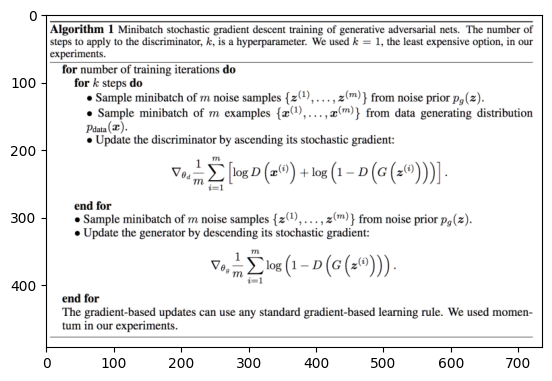

<Figure size 1000x1000 with 0 Axes>

In [3]:
algo = cv2.imread('./gan.png')
plt.imshow(algo)
plt.figure(figsize=(10, 10)) 

In [4]:
class Discriminator(nn.Module):
    def __init__(self, x_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(x_dim, 128),
            nn.LeakyReLU(0.05),  #leaky works better with gans
            nn.Linear(128, 16),
            nn.LeakyReLU(0.05),
            nn.Linear(16, 1),
            nn.Sigmoid()          #we want probabilities
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, x_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.05),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.05),
            nn.Linear(128, x_dim),
            nn.Tanh()               #the input data after tranformed is between [-1,1]
        )

    def forward(self, z):
        return self.gen(z)


class Vanilla_GANS():
    def __init__(self,latent_dim,x_dim):
        self.x_dim = x_dim
        self.latent_dim = latent_dim
        self.generator = Generator(latent_dim, x_dim)
        self.discriminator = Discriminator(x_dim)
        
    def train(self,x_train,k_steps = 2,lr = 5e-4,max_epochs = 50):
        
        optim_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr)
        optim_generator = optim.Adam(self.generator.parameters(), lr=lr)
        criterion = nn.BCELoss ()  #binary cross entropy loss
        error_discriminator = []
        error_generator = []
        
        for epochs in range(max_epochs):
            sum1 = torch.tensor([0.0])
            sum2 = torch.tensor([0.0])
            for batch_idx,(img_data,labels) in enumerate(x_train):
                img_data = img_data.reshape(-1,28*28)
                batch_size = img_data.shape[0]
                random_noice = torch.randn(batch_size,self.latent_dim)
                temp1 = torch.tensor([0.0])
                for k in range(k_steps):
                    #Training discrminator
                    self.discriminator.zero_grad()     #setting accumulated gradients to zero
                         #forward pass
                    D_x = self.discriminator(img_data)
                    D_G_x = self.discriminator(self.generator(random_noice))
                         #even though given ascent we can do descent by adding negative sign
                    loss_discriminator = criterion(D_x,torch.ones_like(D_x)) + criterion(D_G_x,torch.zeros_like(D_G_x))
                    temp1 = loss_discriminator

                    loss_discriminator.backward()  #backwardprop getting gradients
                    optim_discriminator.step()     #update parameters
                    
                sum1 += temp1*batch_size
                #training generator 
                random_noice = torch.randn(batch_size,self.latent_dim)
                self.generator.zero_grad()
                   #forward pass
                D_G_x = self.discriminator(self.generator(random_noice))
                    # even though given descent we can do ascent by max log(D_G_x) rather than min log(1 - D_G_x)
                    # this is because initially D_G_x is 0 cant distinguish properly so log(1 - D_G_x) saturated 
                    
                loss_generator = criterion(D_G_x,torch.ones_like(D_G_x)) # or loss_generator = -torch.log(D_G_x).mean() 
                sum2 += loss_generator*batch_size
                    
                loss_generator.backward()  #backwardprop getting gradients
                optim_generator.step()     #update parameters
                
            # Collect errors after each epoch
            sum1 = sum1/train_dataset.data.shape[0]
            sum2 = sum2/train_dataset.data.shape[0]
            error_discriminator.append(sum1.item())
            error_generator.append(sum2.item())
            
        print(f"the error of discriminator {error_discriminator[-1]} and for generators {error_generator[-1]}")
        epochs = range(1, max_epochs + 1)
        plt.plot(epochs, error_discriminator, label='Discriminator Loss')
        plt.plot(epochs, error_generator, label='Generator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Loss')
        plt.legend()
        plt.show()
        
    def sample(self):
        random_noice = torch.randn(self.latent_dim)
        img = self.generator(random_noice)
        D_G_x = self.discriminator(img)
        return img.reshape(28*28),D_G_x
        

<h4>GANS</h4>

* Architecture: The GAN consists of two main components: the Generator and the Discriminator. The Generator takes random noise as input and generates synthetic data, while the Discriminator tries to distinguish between real and generated data.
* Training Procedure: The GAN training involves iteratively updating the Discriminator and the Generator. The Discriminator is trained to maximize its ability to differentiate between real and generated data, while the Generator is trained to generate data that can fool the Discriminator.
* Loss Function: In this code, the Binary Cross-Entropy Loss (BCELoss) is used as the loss function for both the Discriminator and the Generator. It measures the difference between the predicted and ground truth values, encouraging the Discriminator to correctly classify real and generated data.
* Hyperparameters: The code uses various hyperparameters, such as the learning rate (lr), batch size (batch_size), number of training steps for the Discriminator (k_steps), and maximum number of training epochs (max_epochs). These hyperparameters need to be carefully tuned for optimal GAN training.
* Normalization: The data is normalized using the transforms.Normalize function to ensure that the pixel values are within the range $[-1, 1]$. This is important for the Generator's output to match the distribution of real data.
* Generator and Discriminator Architecture: The Generator and Discriminator are defined as nn.Sequential models with specific layer configurations. They use linear layers with leaky ReLU activation functions to transform the input noise or data into the desired output.
* Training Loop: The training loop iterates over the dataset and updates the Discriminator and Generator based on their respective loss functions. The gradients are computed using backpropagation, and the optimizer is used to update the model parameters.
* Visualization: After training, the code plots the loss curves for the Discriminator and Generator over the training epochs, providing a visual representation of their convergence.

the error of discriminator 0.9593366384506226 and for generators 1.4399051666259766


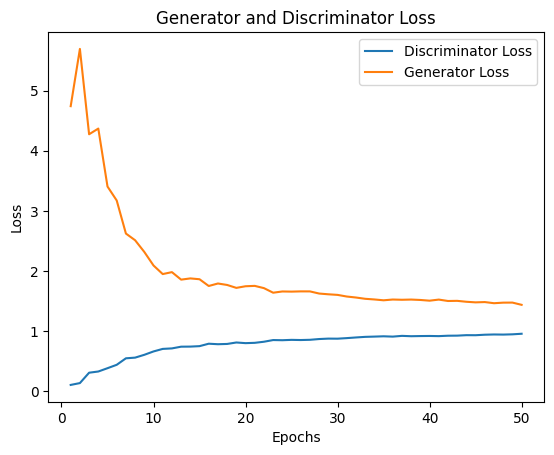

In [5]:
model = Vanilla_GANS(32,28*28*1)
model.train(x_train)

* The Binary Cross-Entropy Loss (BCELoss) is used as the loss function for both the Discriminator and the Generator. It measures the difference between the predicted and ground truth values. In this case, the ground truth for real images (D_x) is set to 1 for all images in the batch, while the ground truth for generated images (D_G_x) is set to 0. The BCELoss function applies the loss calculation to each component individually.
* The mathematical formulation of the BCELoss is given by: criterion$(q, p) = -p * \log(q) - (1 - p) * \log(1 - q)$. Here, q represents the predicted values and p represents the ground truth values.
* GANs are highly sensitive to hyperparameters. Parameters such as the learning rate (lr), batch size (batch_size), number of training steps for the Discriminator (k_steps), and maximum number of training epochs (max_epochs) need to be carefully tuned for effective GAN training.
* Training the Discriminator multiple times (k_steps) before training the Generator has shown significant improvements in training performance. This approach allows the Discriminator to become more effective in distinguishing between real and generated data before the Generator is trained to produce better-quality generated samples.
* The goal in GAN training is to have the Discriminator $(D(x))$ output a value of $0.5$ for real images and the Generator's output $(D(G(x)))$ to also be $0.5$. This indicates that the Generator has become proficient in fooling the Discriminator, while the Discriminator is adequately trained to distinguish between real and generated data.
* The desired loss values for the Generator and Discriminator are as follows: The average loss for the Generator $(loss-generator)$ should be around $log(2) ≈ 0.69$, while the average loss for the Discriminator $(loss-discriminator)$ should be around $log(4) ≈ 1.386$.
<p>For further understanding of GANs, you can refer to the original GAN paper by Ian Goodfellow et al., titled "Generative Adversarial Networks" <href>https://arxiv.org/pdf/1406.2661.pdf</href></p>

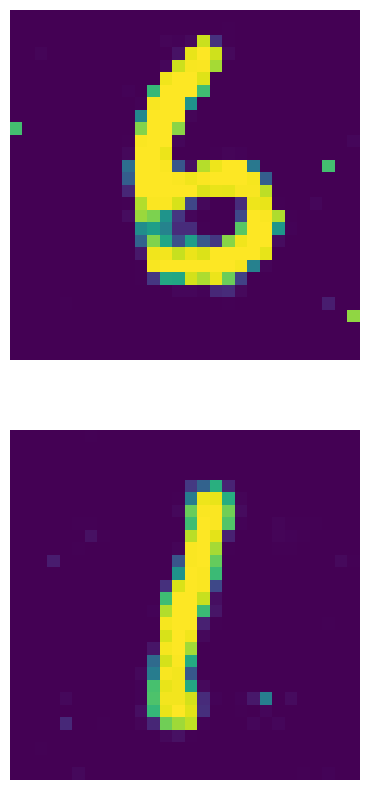

In [19]:
random_noise = torch.randn(2, model.latent_dim)
generated_images = model.generator(random_noise)
generated_images = generated_images.reshape(-1, 28, 28)

fig, axs = plt.subplots(2,1, figsize=(10, 10))
counter = 0

for i in range(2):
    axs[i].imshow(generated_images[counter].detach().numpy())
    axs[i].axis('off')
    counter += 1

plt.show()
